In [1]:
import SimpleITK as sitk

# Read Images

### 1. Nifti File

In [2]:
sitk_file = sitk.ReadImage('avg152T1_LR_nifti.nii.gz')

In [3]:
print(sitk_file)

Image (0x7fffbf03ca30)
  RTTI typeinfo:   itk::Image<unsigned char, 3u>
  Reference Count: 1
  Modified Time: 965
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 942
  UpdateMTime: 964
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [91, 109, 91]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [91, 109, 91]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [91, 109, 91]
  Spacing: [2, 2, 2]
  Origin: [-90, 126, -72]
  Direction: 
1 0 0
0 -1 0
0 0 1

  IndexToPointMatrix: 
2 0 0
0 -2 0
0 0 2

  PointToIndexMatrix: 
0.5 0 0
0 -0.5 0
0 0 0.5

  Inverse Direction: 
1 0 0
0 -1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x7fffbf87bcc0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigned char>
      Reference Count: 1
      Modified Time

### 2. Dicom Series

In [4]:
def ReadDicomSeries(dicom_dir):
    '''
    dicom_dir : dicom directory path
    '''
    
    reader = sitk.ImageSeriesReader()

    # Set Reader's File Names
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
    reader.SetFileNames(dicom_names)

    # Get Image Object from Reader
    sitk_file = reader.Execute()
    
    return sitk_file

In [5]:
sitk_file = ReadDicomSeries('series-000001')

In [6]:
print(sitk_file)

Image (0x7fffc1ed9300)
  RTTI typeinfo:   itk::Image<short, 3u>
  Reference Count: 1
  Modified Time: 13105
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 1124
  UpdateMTime: 13104
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 361]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 361]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 361]
  Spacing: [0.589844, 0.589844, 0.5]
  Origin: [-151.494, -36.6564, 1115]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.589844 0 0
0 0.589844 0
0 0 0.5

  PointToIndexMatrix: 
1.69536 0 0
0 1.69536 0
0 0 2

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x7fffbefe7b80)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, short>
    

### 3. Get numpy array from SimpleITK object

<pre>
※ Notice : 'GetArrayFromImage' method reverses the order of axis.
   For example, if sitk_file.GetSize() returns (100, 200, 300), the numpy array returned by 'GetArrayFromImage' has
   shape (300, 200, 100).
</pre>

In [7]:
img_array = sitk.GetArrayFromImage(sitk_file)

In [8]:
print(img_array.shape)

(361, 512, 512)


### 4. Get header information from SimpleITK object

In [9]:
print("------------------------------------------------------------------")
print("                         Header Information")
print("------------------------------------------------------------------")
print("- Spacing     :", sitk_file.GetSpacing())
print("- Direction   :", sitk_file.GetDirection())
print("- Origin      :", sitk_file.GetOrigin())
print("- Size        :", sitk_file.GetSize())
print("- Pixel Dtype :", sitk_file.GetPixelIDTypeAsString())

------------------------------------------------------------------
                         Header Information
------------------------------------------------------------------
- Spacing     : (0.58984375, 0.58984375, 0.5)
- Direction   : (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
- Origin      : (-151.49351501464844, -36.65644073486328, 1115.0)
- Size        : (512, 512, 361)
- Pixel Dtype : 16-bit signed integer


### 5. Visualization

In [10]:
import matplotlib.pyplot as plt

def PlotImageSlice(sitk_file, slice_index, axis=2, title = 'SimpleITK Example'):
    sitk_slice = sitk_file[:, :, slice_index] if axis == 2 else (sitk_file[:, slice_index] if axis == 1 else sitk_file[slice_index])
    slice_array = sitk.GetArrayFromImage(sitk_slice)
    
    plt.imshow(slice_array, 'gray')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

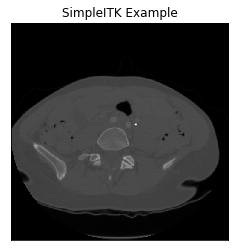

In [11]:
PlotImageSlice(sitk_file, 45, axis=2)

----

# Preprocessing

### 1. Spacing Resampling

In [12]:
import numpy as np

def ResampleImage(sitk_file, new_spacing = (1, 1, 1)):
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetOutputDirection(sitk_file.GetDirection())
    resample.SetOutputOrigin(sitk_file.GetOrigin())
    resample.SetOutputSpacing(new_spacing)

    orig_size = np.array(sitk_file.GetSize(), dtype=np.int)
    orig_spacing = sitk_file.GetSpacing()
    
    orig_spacing = np.array(orig_spacing)
    new_spacing = np.array(new_spacing)
    
    new_size = orig_size*(orig_spacing/new_spacing)
    new_size = np.ceil(new_size).astype(np.int) #  Image dimensions are in integers
    new_size = [int(s) for s in new_size]
    resample.SetSize(new_size)

    return resample.Execute(sitk_file)

In [13]:
sitk_resampled = ResampleImage(sitk_file, new_spacing = (1, 1, 1))

In [14]:
print("Before : Spacing = %30s | Size = %15s" % (sitk_file.GetSpacing(), sitk_file.GetSize()))
print("After  : Spacing = %30s | Size = %15s" % (sitk_resampled.GetSpacing(), sitk_resampled.GetSize()))

Before : Spacing =  (0.58984375, 0.58984375, 0.5) | Size = (512, 512, 361)
After  : Spacing =                (1.0, 1.0, 1.0) | Size = (302, 302, 181)


### 2. N4 Bias Correction

※ Memo : N4 Bias Correction takes a lot of time.

In [17]:
def n4correction_sitk(sitk_file):
    maskImage = sitk.OtsuThreshold(sitk_file, 0, 1, 200)

    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    
    sitk_file = sitk.Cast(sitk_file, sitk.sitkFloat32)
    maskImage.CopyInformation(sitk_file)
    output = corrector.Execute(sitk_file, maskImage)

    return output

In [18]:
sitk_n4_corrected = n4correction_sitk(sitk_file)

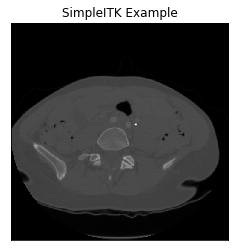

In [19]:
PlotImageSlice(sitk_n4_corrected, 45, axis=2)